In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

/Users/daniela/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:1003: UserWarning: Duplicate key in file "/Users/daniela/.matplotlib/matplotlibrc", line #2
  (fname, cnt))
/Users/daniela/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:1003: UserWarning: Duplicate key in file "/Users/daniela/.matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
df_review = pd.read_csv('dataset/raw/Womens_Clothing_E-Commerce_Reviews.csv', index_col=0)

In [3]:
df_review.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23486 entries, 0 to 23485
Data columns (total 10 columns):
Clothing ID                23486 non-null int64
Age                        23486 non-null int64
Title                      19676 non-null object
Review Text                22641 non-null object
Rating                     23486 non-null int64
Recommended IND            23486 non-null int64
Positive Feedback Count    23486 non-null int64
Division Name              23472 non-null object
Department Name            23472 non-null object
Class Name                 23472 non-null object
dtypes: int64(5), object(5)
memory usage: 2.0+ MB


In [4]:
df_review.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


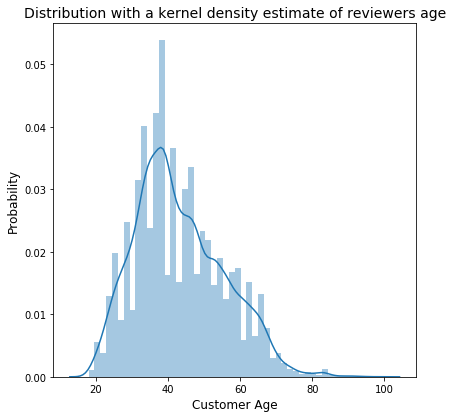

In [5]:
_ = plt.figure(figsize=(6.5, 6.5))
_ = sns.distplot(df_review.Age)
_ = plt.xlabel('Customer Age', size=12)
_ = plt.ylabel('Probability', size=12)
_ = plt.title('Distribution with a kernel density estimate of reviewers age', size=14)

In [6]:
ratings = df_review.groupby(['Rating']).count()['Clothing ID'].reset_index()
ratings['percent'] = 100*ratings['Clothing ID']/ratings['Clothing ID'].sum()

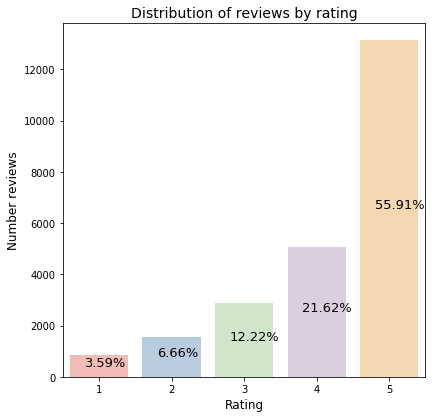

In [7]:
_ = plt.figure(figsize=(6.5, 6.5))
_ = sns.barplot(x=ratings.Rating, y = ratings['Clothing ID'], palette='Pastel1')
_ = plt.xlabel('Rating', size=12)
_ = plt.ylabel('Number reviews', size=12)
_ = plt.title('Distribution of reviews by rating', size=14)

for i in range(len(ratings)):
    _ = plt.text(ratings.Rating[i]-1.2, 
                 ratings['Clothing ID'][i]/2, 
                 str(round(ratings.percent[i], 2))+'%', 
                 fontsize=13)

In [8]:
df_review.groupby('Department Name').count()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Class Name
Department Name,,,,,,,,,
Bottoms,3799,3799,3184,3662,3799,3799,3799,3799,3799
Dresses,6319,6319,5372,6145,6319,6319,6319,6319,6319
Intimate,1735,1735,1408,1653,1735,1735,1735,1735,1735
Jackets,1032,1032,879,1002,1032,1032,1032,1032,1032
Tops,10468,10468,8713,10048,10468,10468,10468,10468,10468
Trend,119,119,107,118,119,119,119,119,119


In [9]:
department = df_review.groupby(['Department Name']).count()['Clothing ID'].reset_index()
department['percent'] = 100*department['Clothing ID']/department['Clothing ID'].sum()

In [10]:
department

,Department Name,Clothing ID,percent
0,Bottoms,3799,16.185242
1,Dresses,6319,26.921438
2,Intimate,1735,7.391786
3,Jackets,1032,4.396728
4,Tops,10468,44.597819
5,Trend,119,0.506987


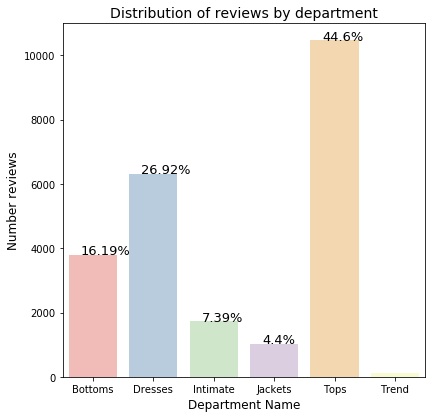

In [11]:
_ = plt.figure(figsize=(6.5, 6.5))
_ = sns.barplot(x=department['Department Name'], y = department['Clothing ID'], palette='Pastel1')
_ = plt.xlabel('Department Name', size=12)
_ = plt.ylabel('Number reviews', size=12)
_ = plt.title('Distribution of reviews by department', size=14)

for i in range(len(ratings)):
    _ = plt.text(i-0.2, 
                 department['Clothing ID'][i], 
                 str(round(department.percent[i], 2))+'%', 
                 fontsize=13)

In [12]:
df_review.groupby(['Department Name', 'Division Name']).count()

Clothing ID   Age  Title  Review Text  Rating  \
Department Name Division Name                                                   
Bottoms         General                2542  2542   2121         2447    2542   
                General Petite         1257  1257   1063         1215    1257   
Dresses         General                3730  3730   3166         3619    3730   
                General Petite         2589  2589   2206         2526    2589   
Intimate        General Petite          233   233    188          227     233   
                Initmates              1502  1502   1220         1426    1502   
Jackets         General                 645   645    547          624     645   
                General Petite          387   387    332          378     387   
Tops            General                6837  6837   5743         6580    6837   
                General Petite         3631  3631   2970         3468    3631   
Trend           General                  96    96     88           95      96   
                General Petite           23    23     19           23      23   

                                Recommended IND  Positive Feedback Count  \
Department Name Division Name                                              
Bottoms         General                    2542                     2542   
                General Petite             1257                     1257   
Dresses         General                    3730                     3730   
                General Petite             2589                     2589   
Intimate        General Petite              233                      233   
                Initmates                  1502                     1502   
Jackets         General                     645                      645   
                General Petite              387                      387   
Tops            General                    6837                     6837   
                General Petite             3631                     3631   
Trend           General                      96                       96   
                General Petite               23                       23   

                                Class Name  
Department Name Division Name               
Bottoms         General               2542  
                General Petite        1257  
Dresses         General               3730  
                General Petite        2589  
Intimate        General Petite         233  
                Initmates             1502  
Jackets         General                645  
                General Petite         387  
Tops            General               6837  
                General Petite        3631  
Trend           General                 96  
                General Petite          23